# **2023 Spring AI501 Homework Assignment 6 (60 points)**
In this homework, we will implement a simple Vision Transformer (ViT) using PyTorch. Read the following problem sheet and submit your completed $\texttt{ipynb}$ file.

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm, trange

import torchvision.transforms as TF
import torch.nn as nn
import numpy as np
import torchvision
import torch

!pip install einops

from torch import einsum
from einops import rearrange

np.random.seed(0)
torch.manual_seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.7 MB/s eta 0:00:00


---
---

# Implementation of ViT model

During the implementation, we will refer to the following figure that well exhibits the architecture of ViT. The original image is provided by [Bazi et al. (2021)](https://www.researchgate.net/publication/348947034_Vision_Transformers_for_Remote_Sensing_Image_Classification).

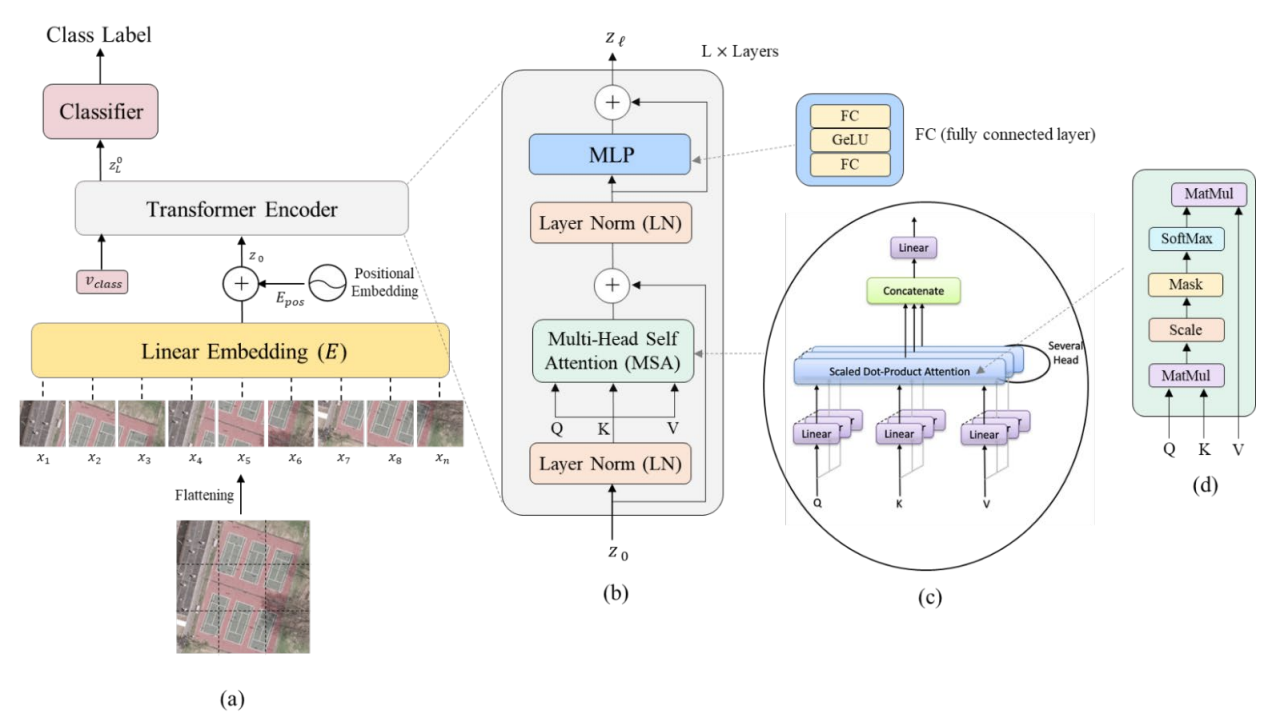

Let's briefly explore the workings of the ViT-based classifier based on the provided diagram.

The image is first divided into equally sized sub-images (i.e., patches), as depicted in (a). Each sub-image then undergoes a linear embedding, transforming it into a one-dimensional vector.

To preserve spatial information, a positional embedding is added to each vector (i.e., tokens), enabling the network to understand the original position of each sub-image within the image. This positional information is crucial for accurate predictions.

These tokens, along with a special classification token (i.e., $v_{class}$), are then passed through a series of transformer encoder blocks. Each block consists of a Layer Normalization (LN) followed by Multi-head Self Attention (MSA) and a residual connection. This is followed by another LN, a Multi-Layer Perceptron (MLP), and another residual connection. These blocks are connected consecutively, allowing information to flow through the network.

Finally, a classification MLP block is employed solely on the special classification token, which, after this process, contains global information about the entire image. This MLP block is responsible for the final classification task.

Constructing a ViT architecture from scratch, even a small-scaled version that we are specifically interested in, is not that straightforward. Hence, we take a step-by-step approach for it. Our journey starts with an empty *nn.Module* to which we sequentially add components, referencing the above figure to ensure proper alignment.

In [ ]:
class MyViT(nn.Module):
  def __init__(self):
    # Super constructor
    super(MyViT, self).__init__()

  def forward(self, images):
    pass

---

## Step 1: Patchifying and the linear mapping (5 points)

The first step is to "patchify" a given input image, i.e., breaking it into multiple sub-images. One can do so by simply reshaping the input, which has size $(N, C, H, W)$, to size $(N, \text{# of patches}, \text{patch dimensionality})$, where the dimensionality of a patch is adjusted accordingly. Specifically in our MNIST example with $(N, 1, 28, 28)$, we can break them into $7 \times 7$ patches (hence each patch of size $4 \times 4$) and obtain $(N, 49, 16)$ tensor.

### Step 1-1: Patchifying

Complete the following code for patchifying images, where an input image is divided into $\texttt{n_patches} \times \texttt{n_patches}$ sub-images. $\texttt{n_patches}$ indicates the number of patches both in width and height of images. Note that the patchfied images should be flatten to go through a linear embedding layer that we will shortly implement.

In [ ]:
def patchify(images, n_patches):
    n, c, h, w = images.shape

    assert h == w, "Patchify method is implemented for square images only"

    patches = torch.zeros(n, n_patches ** 2, h * w * c // n_patches ** 2)
    patch_size = h // n_patches

    for idx, image in enumerate(images):
        for i in range(n_patches):
            for j in range(n_patches):
                ######################################################################
                patch = image[0, i * patch_size: (i + 1) * patch_size, j * patch_size: (j + 1) * patch_size].reshape(h * w * c // n_patches ** 2) # fill here
                patches[idx, i * n_patches + j] = patch# fill here
                ######################################################################

    return patches

Incorporating the implemented patchification into our empty $\texttt{MyViT}$ class would be like this:

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"

  def forward(self, images):
    patches = patchify(images, self.n_patches).to(images.device)
    return patches

Run the code below to check your implementation of $\texttt{patchify}$ function. If correctly done, this would yield $(7,49,16)$ tensor.

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 16])

torch.Size([7, 49, 16])


### Step 1-2: Linear mapping

Having obtained our flattened patches, we proceed to perform a Linear mapping on each of them. Initially, the patches are represented as 16-dimensional vectors due to their $4 \times 4 = 16$ size. With the flexibility of the linear mapping, we can map them to vectors of any desired dimension. To accommodate this flexibility, our class constructor includes a parameter called $\texttt{hidden_d}$, denoting the hidden dimension. In the present example, we set the hidden dimension to 8, but it can be adjusted to any desired value. Consequently, each 16-dimensional patch will be mapped to an 8-dimensional patch.

Complete the code below to construct $\texttt{MyViT}$ class that includes the linear mapping operation. You may want to use *nn.Linear* class for declaring the linear mapping.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    ######################################################################
    self.input_d = int(self.patch_size[0]) ** 2# fill here
    self.linear_mapper = nn.Linear(self.input_d, hidden_d)# fill here
    ######################################################################

  def forward(self, images):
    patches = patchify(images, self.n_patches).to(images.device)
    tokens = self.linear_mapper(patches)
    return tokens

Run the code below for a sanity check of your linear mapping implemetation. If correctly done, this would yield $(7,49,8)$ tensor.

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=8
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 49, 8])

torch.Size([7, 49, 8])


---

## Step 2: Positional encoding (5 points)

We move onto the step of adding positional encoding. In each sequence, for token $i$, we add to its $j$-th coordinate the following value:

$p_{i, j}= \begin{cases}\sin \left(\frac{i}{10000^{\frac{j}{d_{\text{emb-dim}}}}}\right) & \text { if } j \text { is even } \\ \cos \left(\frac{i}{10000^{\frac{j-1}{d_{\text{emb-dim}}}}}\right) & \text { if } j \text { is odd }\end{cases}$

This positional embedding is a function of the number of elements in the sequence and the dimensionality of each element. Thus, it is always a 2-dimensional tensor or "rectangle".

Complete the following function that, given the number of tokens and the dimensionality of each of them, outputs a matrix where each coordinate $(i,j)$ is the value to be added to token $i$ in dimension $j$.

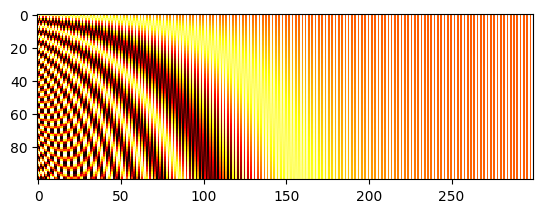

In [ ]:
import math
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            ######################################################################
            result[i][j] = math.sin(i/10000 ** (j/d)) if (j%2 == 0) else math.cos(i/10000 ** (j/d))# fill here
            ######################################################################

    return result

# Run this code to check your implementation
if __name__ == "__main__":
  import matplotlib.pyplot as plt

  plt.imshow(get_positional_embeddings(100, 300), cmap="hot", interpolation="nearest")
  plt.show()

If implemented correctly, you would see a heatmap plot as below figure. Notice that all "horizontal lines" are all different from each other, meaning that each individual patches are distinguishable.

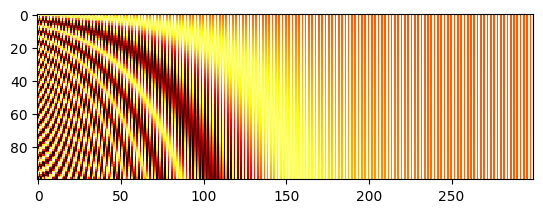

Complete the following code. You have to declare a positional embedding that is currently used in the forward pass (as $\texttt{self.pos_embed}$) by employing $\texttt{get_positional_embeddings}$ function that you have implemented above.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    # place your code implemented in Step 1
    ######################################################################
    self.input_d = int(self.patch_size[0]) ** 2# fill here
    self.linear_mapper = nn.Linear(self.input_d, hidden_d)# fill here
    ######################################################################

    # 2) Positional embedding
    ######################################################################
    self.pos_embed = get_positional_embeddings(n_patches ** 2, hidden_d)# fill here
    self.pos_embed.requires_grad = False
    ######################################################################

  def forward(self, images):
    patches = patchify(images, self.n_patches).to(images.device)
    tokens = self.linear_mapper(patches)

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    out = tokens + pos_embed

    return out

---

## Step 3: Adding the classification token (5 points)

The next step is putting a classification token (i.e., $v_{class}$) on top of the positionally-encoded image patches.

Complete the following code where you have to declare a classification token which is used in the forward pass as $\texttt{self.class_token}$. You may want to use *nn.Parameter* to define a learnable class token.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw=(1, 28, 28), n_patches=7, hidden_d=8):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    # place your code implemented in Step 1
    ######################################################################
    self.input_d = int(self.patch_size[0]) ** 2# fill here
    self.linear_mapper = nn.Linear(self.input_d, hidden_d)# fill here
    ######################################################################

    # 2) Positional embedding
    ######################################################################
    self.pos_embed = get_positional_embeddings(n_patches ** 2, hidden_d)# fill here
    self.pos_embed.requires_grad = False
    ######################################################################

    # 3) Learnable classifiation token
    ######################################################################
    self.class_token = nn.Parameter(torch.Tensor(1, hidden_d))# fill here
    ######################################################################

  def forward(self, images):
    patches = patchify(images, self.n_patches).to(images.device)
    tokens = self.linear_mapper(patches)

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    out = tokens + pos_embed

    # Adding classification token
    out = torch.stack([torch.vstack((self.class_token, out[i])) for i in range(len(out))])

    return out

Use the code below to check your implementation. If correctly done, this would yield $(7,50,8)$ tensor.

In [ ]:
if __name__ == '__main__':
  # Current model
  model = MyViT(
    chw=(1, 28, 28),
    n_patches=7,
    hidden_d=8
  )

  x = torch.randn(7, 1, 28, 28) # Dummy images
  print(model(x).shape) # torch.Size([7, 50, 8])

torch.Size([7, 50, 8])


---

## Step 4: The encoder block (Part 1/2) (25 points)

Building the encoder block is a bit challenging, so we divide the procedure into two parts. The first part comprises the application of Layer Normalization (LN) to our tokens, then a Multi-head Self Attention (MSA), and finally adds a residual connection.

Due to the complexity of its architecture, we introduce a dedicated class for the encoder block. Below we provide an empty class for it.

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

    def forward(self, x):
        pass

### Step 4-1: Layer Normalization (5 of 25 points)

Complete the following code. On top of the above empty class, you are expected to declare an LN layer used in the forward pass. You may want to use *nn.LayerNorm* which is a built-in class provided in PyTorch.

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        ######################################################################
        self.norm1 = nn.LayerNorm(hidden_d)# fill here
        ######################################################################

    def forward(self, x):
        out = self.norm1(x)
        return out

### Step 4-2: Multi-head Self Attention (5 of 25 points)

Now we move onto implementation of the most imporatant part in the ViT architecture: Multi-head Self Attention (MSA). Before working on the code, we briefly go over how it works.

Self-attention mechanism in our ViT context enables us to update each patch (w.r.t. a single image) based on similarities with the other patches. In order to do so, we first linearly map each patch (that is now an 8-dimensional vector in our example) to 3 distinct vectors: $q$, $k$, and $v$ (i.e., query, key, value). Then for a single patch, we compute the dot product between its $q$ vector with all of the $k$ vectors, divide by the square root of the dimensionality of these vectors ($\sqrt{8}$), softmax these so-called attention cues, and finally multiply each attention cue with the $v$ vectors associated with the different $k$ vectors and sum all up. This whole procedure is carried out $H$ times on $H$ sub-vectors of our current 8-dimensional patches, where $H$ is the number of Heads.

Complete the following code where you are expected to fill the details on updating patches based on self-attention mechanism described above. In our implementation, we focus on the case with 2 attention heads, i.e., $H=2$. Since our inputs will be sequences of size $(N, 50, 8)$, and we only use 2 heads, we will at some point have an $(N, 50, 2, 4)$ tensor, use a $\text{nn.Linear(4, 4)}$ module on it, and then come back, after concatenation, to an $(N, 50, 8)$ tensor.

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / n_heads)
        self.q_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.k_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.v_mappings = nn.ModuleList([nn.Linear(d_head, d_head) for _ in range(self.n_heads)])
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.n_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                ######################################################################
                attention = self.softmax(torch.matmul(q, k.transpose(-2, -1)/math.sqrt(self.d)))# fill here
                output = torch.matmul(attention, v)
                seq_result.append(output)#(fill here)
                ######################################################################

            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

### Step 4-2 (Challenge): Parallel Multi-head Self Attention (10 of 25 points)

The previous block of code implemented MSA with for loops for ease of understanding. Now, try to implement a parallel version of MSA, which does not have any for loops. It may be convenient to use ``torch.einsum`` and ``einops.rearrange`` modules. **Each variable must be calculated with one line of code.**

In [ ]:
class MyMSA(nn.Module):
    def __init__(self, d, n_heads=2):
        super(MyMSA, self).__init__()
        self.d = d
        self.n_heads = n_heads

        assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        self.d_head = int(d / n_heads)
        self.qkv_mapping = nn.Linear(d, 3*d)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)

        ######################################################################
        qkv = # fill here
        q, k, v = # fill here
        attention = # fill here
        seq_result = # fill here
        result = # fill here
        ######################################################################

        return result

SyntaxError: ignored

### Step 4-3: Residual connection (5 of 25 points)

A residual connection involves adding the original input to the output of a computational step. We will incorporate a residual connection, where the original $(N, 50, 8)$ tensor is added to the $(N, 50, 8)$ tensor obtained after applying LN and MSA.

Complete the following code. You are required to add your MSA operation in the existing $\texttt{MyViTBlock}$ (used in Step 4-1), as well as putting the residual connection in the forward pass.

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        # 1) LN-1
        # place your code implemented in Step 4-1
        ######################################################################
        self.norm1 = nn.LayerNorm(hidden_d)# fill here
        ######################################################################

        # 2) MSA
        ######################################################################
        self.mhsa = MyMSA(self.hidden_d)# fill here
        ######################################################################

    def forward(self, x):
        out = self.norm1(x)

        # 3) Residual connection-1
        ######################################################################
        out = self.mhsa(out) + x# fill here
        ######################################################################

        return out

---

## Step 5: The encoder block (Part 2/2) (5 points)

The second part is to establish a residual connection between the existing tensor and the result obtained after applying another LN and MLP to the current tensor. The MLP consists of two layers, where the size of the hidden layer is usually four times larger (this can be adjusted with a parameter, i.e., $\texttt{mlp_ratio}$). In this implementation, you can set the dimension of the MLP hidden layer as $\texttt{mlp_ratio} \times \texttt{hidden_d}$. As shown in the reference figure (in (b)), you are expected to employ $\texttt{GeLU}$ as the activation function in the MLP.

Complete the code below while respecting the above description.

In [ ]:
class MyViTBlock(nn.Module):
    def __init__(self, hidden_d, n_heads, mlp_ratio=4):
        super(MyViTBlock, self).__init__()
        self.hidden_d = hidden_d
        self.n_heads = n_heads

        # 1) LN-1
        # place your code implemented in Step 4-1
        ######################################################################
        self.norm1 = nn.LayerNorm(hidden_d)# fill here
        ######################################################################

        # 2) MSA
        # place your code implemented in Step 4-3
        ######################################################################
        self.mhsa = MyMSA(self.hidden_d)# fill here
        ######################################################################

        # 4) LN-2 & MLP
        ######################################################################
        self.norm2 = nn.LayerNorm(hidden_d)# fill here
        mlp_hidden_d = hidden_d * mlp_ratio
        self.mlp = nn.Sequential(
            nn.Linear(hidden_d, mlp_hidden_d),
            nn.GELU(),
            nn.Linear(mlp_hidden_d, hidden_d)
        )# fill here
        ######################################################################


    def forward(self, x):
        out = self.norm1(x)

        # 3) Residual connection-1
        # place your code implemented in Step 4-3
        ######################################################################
        out = self.mhsa(out) + x# fill here
        ######################################################################

        # 4) LN-2 & MLP
        ######################################################################
        out = self.norm2(out)# fill here
        out = self.mlp(out)
        ######################################################################

        return out

You can use the following code to check that the Encoder block outputs a tensor of the same dimensionality:

In [ ]:
if __name__ == '__main__':
  model = MyViTBlock(hidden_d=8, n_heads=2)

  x = torch.randn(7, 50, 8)  # Dummy sequences
  print(model(x).shape)      # torch.Size([7, 50, 8])

With the completion of the encoder block, our focus shifts to integrating it into our larger ViT model, which handles the patchification process before the transformer blocks and performs classification afterwards. The number of transformer blocks can vary as desired. In this instance, for the sake of simplicity, we will employ only two blocks. Additionally, we introduce a parameter to determine the number of heads each encoder block will utilize.

Complete the following code where you are required to declare the encoder blocks employed in the forward pass of the ViT model.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.n_blocks = n_blocks
    self.n_heads = n_heads
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    # place your code implemented in Step 1
    ######################################################################
    self.input_d = int(self.patch_size[0]) ** 2# fill here
    self.linear_mapper = nn.Linear(self.input_d, hidden_d)# fill here
    ######################################################################

    # 2) Positional embedding
    # place your code implemented in Step 2
    ######################################################################
    self.pos_embed = get_positional_embeddings(n_patches ** 2, hidden_d)# fill here
    self.pos_embed.requires_grad = False
    ######################################################################

    # 3) Learnable classifiation token
    # place your code implemented in Step 3
    ######################################################################
    self.class_token = nn.Parameter(torch.Tensor(1, hidden_d))# fill here
    ######################################################################

    # 4) Transformer encoder blocks
    ######################################################################
    self.blocks = nn.ModuleList([
        MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)
    ])# fill here
    ######################################################################


  def forward(self, images):
    patches = patchify(images, self.n_patches).to(images.device)
    tokens = self.linear_mapper(patches)

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1)
    out = tokens + pos_embed

    # Adding classification token
    out = torch.stack([torch.vstack((self.class_token, out[i])) for i in range(len(out))])

    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    return out

---

## Step 6: Classification MLP (5 points)

Lastly, we extract the classification token (the initial token) from our set of N sequences and employ each token to generate $N$ classifications. Considering that we have designated each token as an 8-dimensional vector and there are 10 potential digits in MNIST, we can implement the classification MLP via an $8 \times 10$ matrix. The matrix is then activated using the SoftMax function.

Complete the following code where your job is to define a MLP layer together with the SoftMax function as described above.

In [ ]:
class MyViT(nn.Module):
  def __init__(self, chw, n_patches=7, n_blocks=2, hidden_d=8, n_heads=2, out_d=10):
    # Super constructor
    super(MyViT, self).__init__()

    # Attributes
    self.chw = chw # (C, H, W)
    self.n_patches = n_patches
    self.n_blocks = n_blocks
    self.n_heads = n_heads
    self.hidden_d = hidden_d

    assert chw[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    assert chw[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
    self.patch_size = (chw[1] / n_patches, chw[2] / n_patches)

    # 1) Linear mapper
    # place your code implemented in Step 1
    ######################################################################
    self.input_d = int(self.patch_size[0]) ** 2# fill here
    self.linear_mapper = nn.Linear(self.input_d, hidden_d)# fill here
    ######################################################################

    # 2) Positional embedding
    # place your code implemented in Step 2
    ######################################################################
    self.pos_embed = get_positional_embeddings(n_patches ** 2, hidden_d)# fill here
    self.pos_embed.requires_grad = False
    ######################################################################

    # 3) Learnable classifiation token
    # place your code implemented in Step 3
    ######################################################################
    self.class_token = nn.Parameter(torch.Tensor(1, hidden_d))# fill here
    ######################################################################

    # 4) Transformer encoder blocks
    # place your code implemented in Step 5
    ######################################################################
    self.blocks = nn.ModuleList([
        MyViTBlock(hidden_d, n_heads) for _ in range(n_blocks)
    ])# fill here
    ######################################################################

    # 5) Classification MLP
    ######################################################################
    self.mlp = nn.Sequential(
        nn.Linear(hidden_d, out_d),  # Linear layer
        nn.Softmax(dim=1)  # Softmax activation
    )# fill here
    ######################################################################


  def forward(self, images):
    patches = patchify(images, self.n_patches).to(images.device)
    tokens = self.linear_mapper(patches)

    # Adding positional embedding
    pos_embed = self.pos_embed.repeat(images.shape[0], 1, 1).to(images.device)
    out = tokens + pos_embed
    # Adding classification token
    out = torch.stack([torch.vstack((self.class_token, out[i])) for i in range(len(out))])
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)
    # Getting the classification token only
    out = out[:, 0]
    # print(out)
    # print(self.mlp(out))
    return self.mlp(out) # Map to output dimension, output category distribution

---

## Step 7: Training (10 points)

We now train our VIT model to classify images from Fasion MNIST.

### Step 7-1: Loading Data (3 of 10 points)

Using the torchvision.transforms module, create transformations which...
- normalize training dataset images into [0,1], apply Random Horizontal Flipping, apply Random Resized Cropping
- normalize test dataset images into [0,1]

Using the torchvision.datasets module...
- Load the FashionMNIST train and test dataset and apply the transformations

Using the torch.utils.data.DataLoader module...
- Create train and test dataset loaders of batch size 128

In [ ]:
######################################################################

transform_train = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.0,), (1.0,))
])# fill here
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.0,), (1.0,))
])# fill here

train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform_train)
# fill here
test_set = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform_test)# fill here

train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)# fill here
test_loader = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)# fill here

######################################################################

# Visualize training dataset
for X, y in train_loader:

    plt.figure(figsize=(30,3))
    for i in range(10):
        plt.subplot(1,10,i+1)
        plt.imshow(X[i].reshape(28,28), cmap='gray', vmin=0, vmax=1)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout()
    plt.show()

    break

### Step 7-2: Defining Model, Optimizer, and Loss  (2 of 10 points)

- Create a VIT model and place the parameters on GPU
- With torch.optim, create an Adam optimizer with initial learning rate 0.001
- With torch.optim, create a learning rate scheduler which decays the learning rate by 0.5 every 30 epochs
- With torch.nn, create a Cross Entropy Loss function

In [ ]:
######################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyViT(chw=(1, 28, 28)).to(device)# fill here
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # fill here
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5) # fill here
criterion = nn.CrossEntropyLoss()# fill here
######################################################################

### Step 7-3: Training Loop (3 of 10 points)
- Train the VIT model for 100 epochs (it will take around 5 to 10 hours, depending on the size of the model)
- You must place each batch from the train_loader onto the GPU
- At the end of each epoch, print the average training loss and average classification accuracy (on training set)

In [ ]:
model.train()

for epoch in range(100):
    avg_train_loss = 0
    avg_train_acc = 0

    for X, y in tqdm(train_loader, desc='Epoch {}'.format(epoch+1)):
        ######################################################################
        X, y = X.to(device), y.to(device)# fill here
        y_pred = model(X)# fill here
        # print(y_pred.shape)
        # print(y, y_pred)
        loss = criterion(y_pred, y)# fill here
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        avg_train_loss += loss.item()# fill here
        avg_train_acc += (y_pred.argmax(dim=1) == y).sum().item()/len(y)# fill here
        # print(avg_train_acc)
        # print(avg_train_loss)
    avg_train_loss = avg_train_loss/len(train_loader)
    avg_train_acc = avg_train_acc/len(train_loader)
    # print(avg_train_acc)
        ######################################################################

    scheduler.step()
    print('Epoch {} | Train Loss : {:.3f} | Train Acc : {:.3f}'.format(epoch+1, avg_train_loss, avg_train_acc))

### Step 7-4: Evaluation (2 of 10 points)
- Place the batch on GPU
- Calculate the accuracy of trained model on test dataset

In [ ]:
model.eval()
test_acc = 0

for X, y in tqdm(test_loader, desc='Evaluating...'):
    ######################################################################
    X, y = X.to(device), y.to(device)# fill here
    y_pred = model(X)# fill here
    test_acc += (y_pred.argmax(dim=1) == y).sum().item()# fill here
    ######################################################################
test_acc /= test_loader.dataset
print('\nTest Accuracy : {:.3f}'.format(test_acc))

Note that learning is sometimes unstationary.
Sometimes loss is calculated to NaN and learning does not occur.
Here is image for the case learning properly happend.
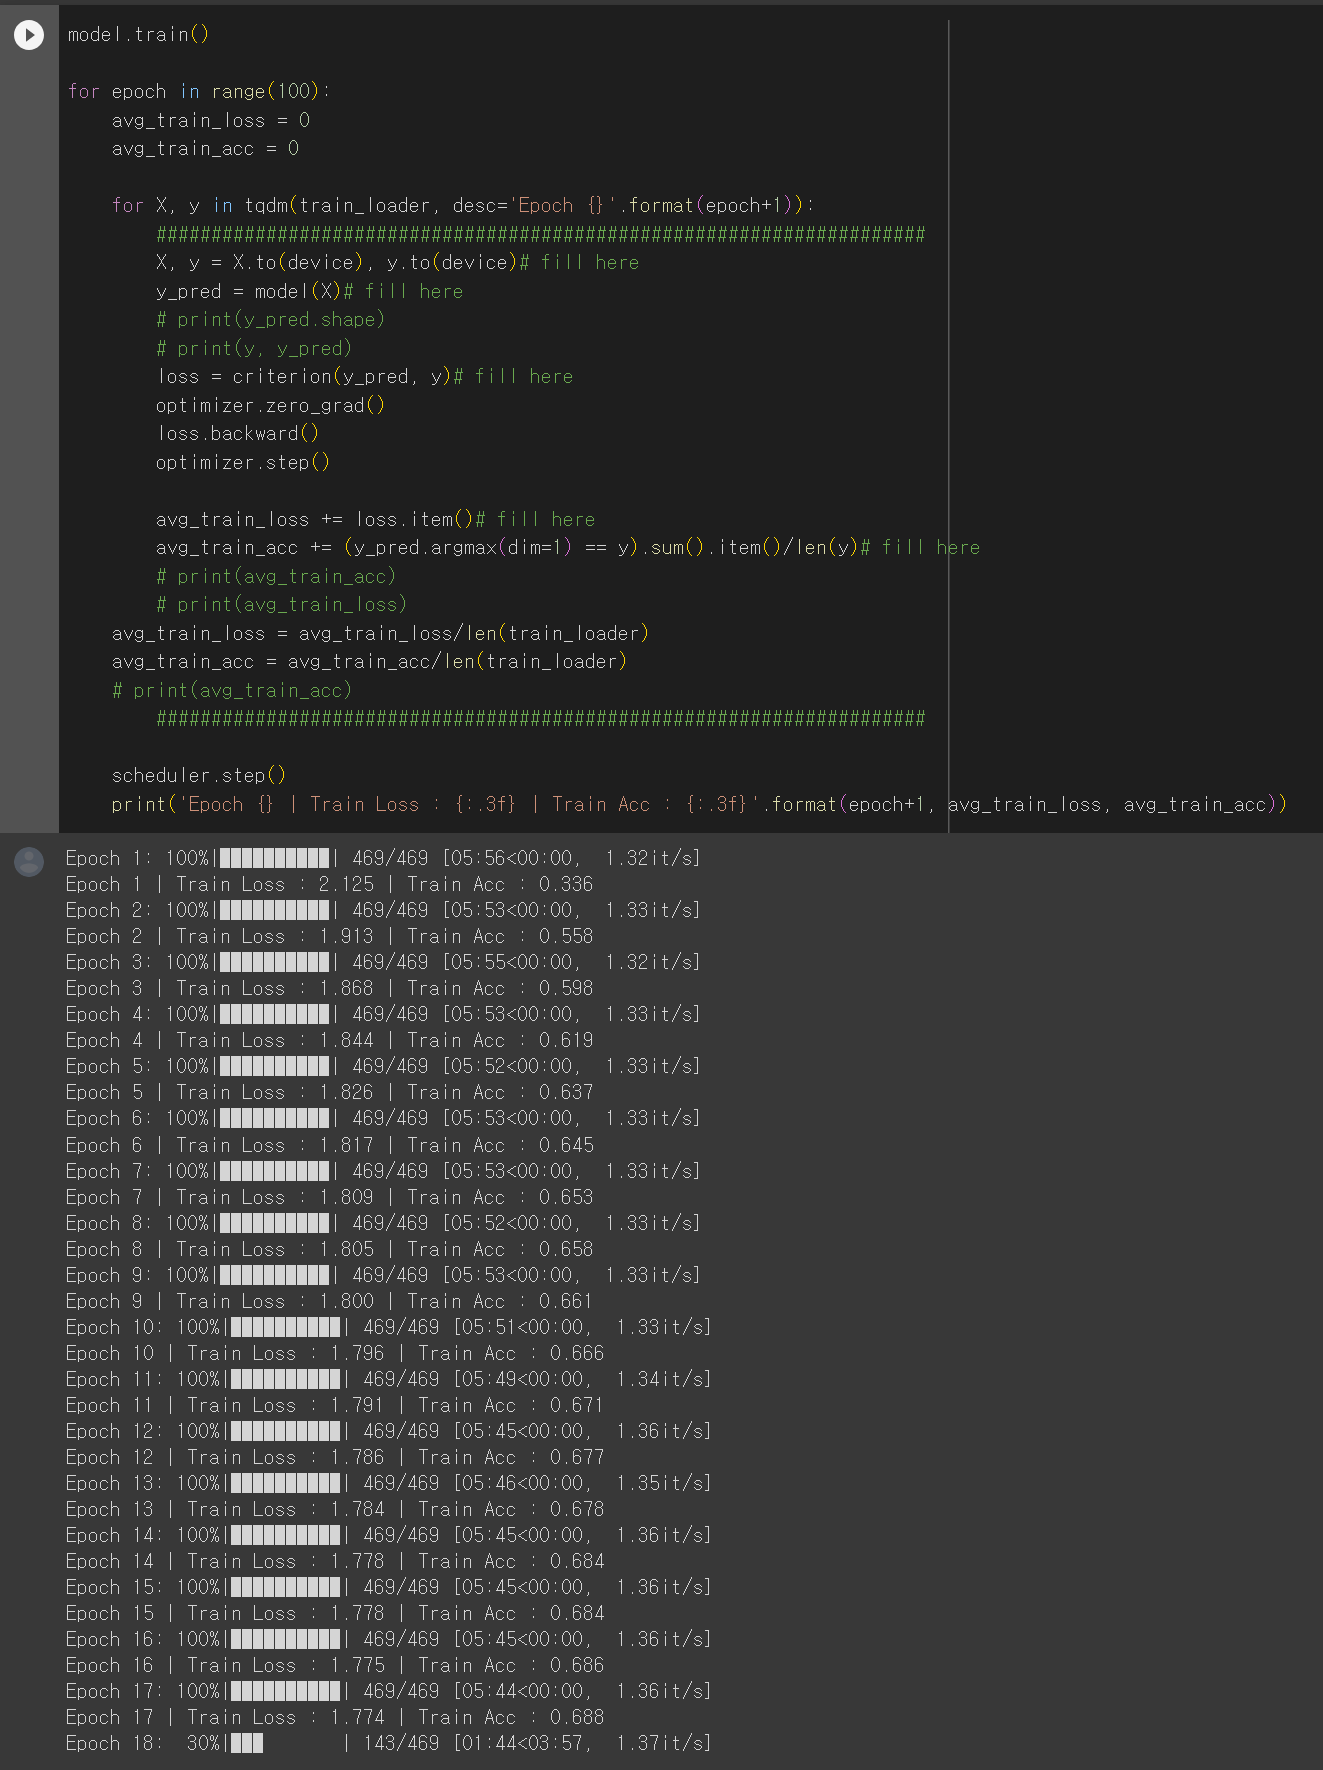